### Pre-task 2.6


Simulation Results:
λ	| M[N] theor	| M[N] async	| M[N] sync	| M[D] async theor	| M[D] async pract	| M[D] sync theor	| M[D] sync pract
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.106	| 0.106	| 1.056	| 1.054	| 1.556	| 1.547
0.2	| 0.225	| 0.227	| 0.224	| 1.125	| 1.129	| 1.625	| 1.620
0.3	| 0.364	| 0.363	| 0.365	| 1.214	| 1.216	| 1.714	| 1.718
0.4	| 0.533	| 0.549	| 0.534	| 1.333	| 1.350	| 1.833	| 1.830
0.5	| 0.750	| 0.743	| 0.737	| 1.500	| 1.497	| 2.000	| 1.978
0.6	| 1.050	| 1.050	| 1.046	| 1.750	| 1.753	| 2.250	| 2.236
0.7	| 1.517	| 1.519	| 1.558	| 2.167	| 2.179	| 2.667	| 2.689
0.8	| 2.400	| 2.366	| 2.313	| 3.000	| 3.005	| 3.500	| 3.389
0.9	| 4.950	| 4.702	| 5.301	| 5.500	| 5.238	| 6.000	| 6.426


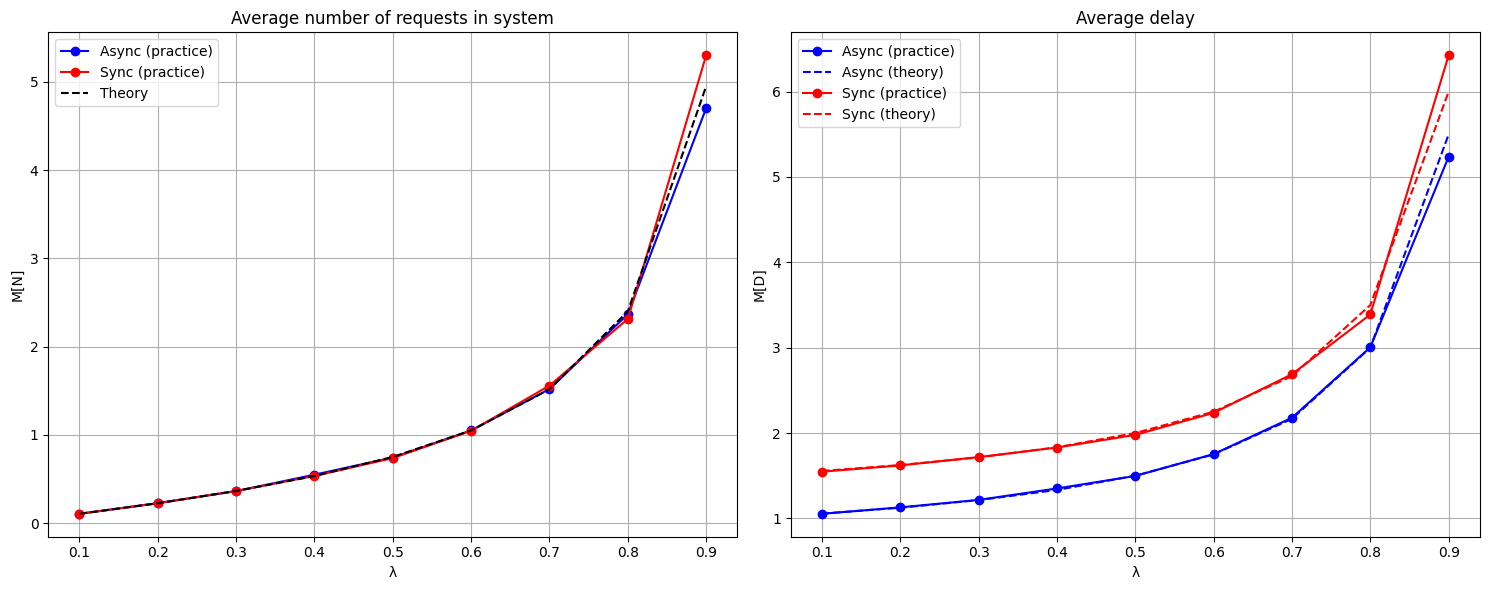

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.mu = 1.0
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = deque()
        self.completed_requests: List[Request] = []
        
    def generate_arrival_times(self, size: int) -> List[float]:
        tau = np.random.exponential(1/self.lambda_param, size)
        return np.cumsum(tau)
        
    def calculate_average_messages(self, timeline: List[float]) -> float:
        M_N = 0
        cur_mes = 0
        number_windows = int(np.ceil(timeline[-1]))
        
        queue = deque()
        for i in range(number_windows):
            if queue:
                queue.popleft()
            while cur_mes < len(timeline) and timeline[cur_mes] < i:
                queue.append(cur_mes)
                cur_mes += 1
            M_N += len(queue)
            
        return M_N / number_windows if number_windows > 0 else 0

    def simulate(self, size: int = 100000):
        timeline = self.generate_arrival_times(size)
        times_send = [0.0]  # Start with initial time
        total_delay = 0
        
        t = np.ceil(timeline[0]) + 1
        total_delay += (t - timeline[0])
        times_send.append(t)
        
        for i in range(1, len(timeline)):
            if self.is_synchronous:
                t = np.ceil(timeline[i])
                if t >= times_send[-1]:
                    t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
                else:
                    while t < times_send[-1] + 1:
                        t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
            else:  # Asynchronous
                t = timeline[i]
                if t >= times_send[-1]:
                    t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
                else:
                    t = times_send[-1] + 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
        
        avg_delay = total_delay / size
        avg_messages = self.calculate_average_messages(timeline)
        
        return avg_delay, avg_messages

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    N = (lambda_param * (2 - lambda_param)) / (2 * (1 - lambda_param))
    
    D_async = (2 - lambda_param) / (2 * (1 - lambda_param))
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], size: int):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nSimulation Results:")
    print("λ\t| M[N] theor\t| M[N] async\t| M[N] sync\t| M[D] async theor\t| M[D] async pract\t| M[D] sync theor\t| M[D] sync pract")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        D_async, N_async = async_system.simulate(size)
        
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        D_sync, N_sync = sync_system.simulate(size)
        
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Async (practice)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Sync (practice)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Theory')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Average number of requests in system')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Async (practice)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Async (theory)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Sync (practice)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Sync (theory)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Average delay')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

lambda_params = np.linspace(0.1, 0.9, 9)
results = compare_systems(lambda_params, 10_000)
plot_results(lambda_params, results)


Simulation Results:
λ	| M[N] theor	| M[N] async	| M[N] sync	| M[D] async theor	| M[D] async pract	| M[D] sync theor	| M[D] sync pract
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.105	| 0.106	| 1.056	| 1.055	| 1.556	| 1.556
0.2	| 0.225	| 0.225	| 0.225	| 1.125	| 1.125	| 1.625	| 1.625
0.3	| 0.364	| 0.363	| 0.365	| 1.214	| 1.213	| 1.714	| 1.715
0.4	| 0.533	| 0.532	| 0.534	| 1.333	| 1.333	| 1.833	| 1.835
0.5	| 0.750	| 0.749	| 0.752	| 1.500	| 1.498	| 2.000	| 2.003
0.6	| 1.050	| 1.053	| 1.049	| 1.750	| 1.753	| 2.250	| 2.250
0.7	| 1.517	| 1.516	| 1.516	| 2.167	| 2.167	| 2.667	| 2.665
0.8	| 2.400	| 2.387	| 2.394	| 3.000	| 2.985	| 3.500	| 3.494
0.9	| 4.950	| 4.932	| 4.982	| 5.500	| 5.483	| 6.000	| 6.034


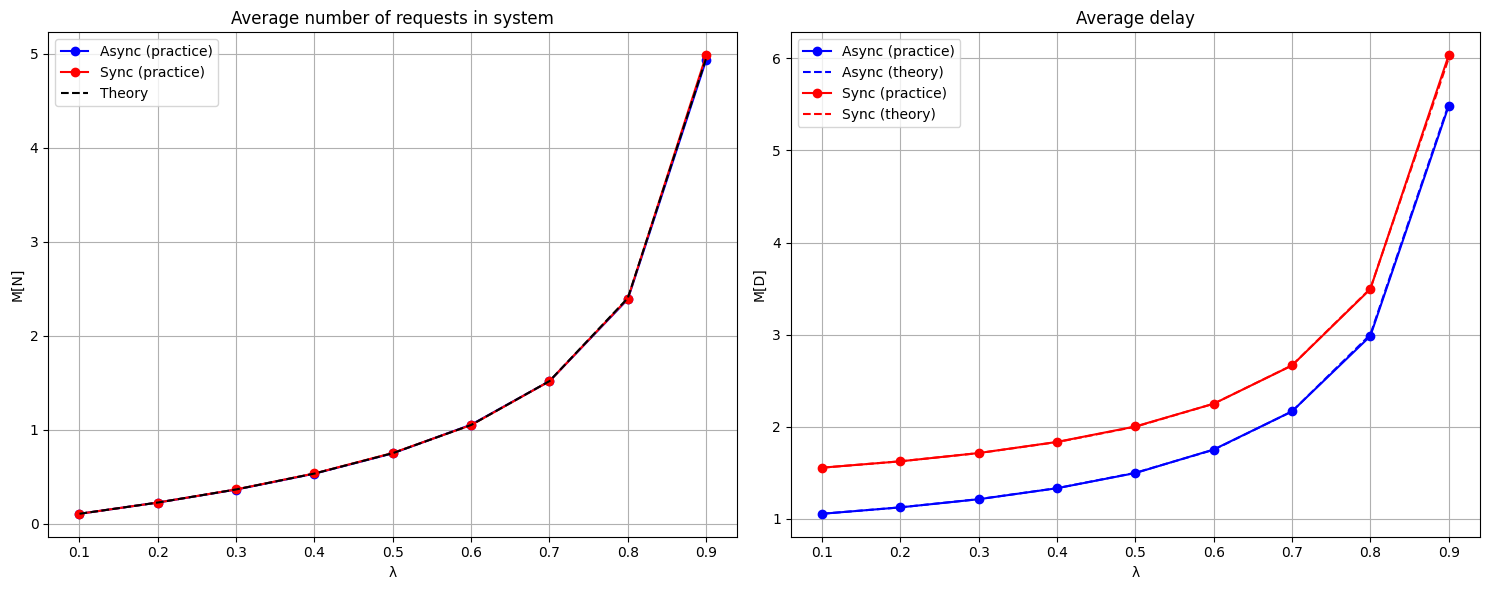

In [ ]:
lambda_params = np.linspace(0.1, 0.9, 9)
results = compare_systems(lambda_params, 1_000_000)
plot_results(lambda_params, results)

## Dop - LIFO


Simulation Results (LIFO Queue):
λ	| M[N] theor	| M[N] async	| M[N] sync	| M[D] async theor	| M[D] async pract	| M[D] sync theor	| M[D] sync pract
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.105	| 0.106	| 1.056	| 1.052	| 1.556	| 1.556
0.2	| 0.225	| 0.219	| 0.224	| 1.125	| 1.118	| 1.625	| 1.627
0.3	| 0.364	| 0.370	| 0.374	| 1.214	| 1.225	| 1.714	| 1.724
0.4	| 0.533	| 0.531	| 0.533	| 1.333	| 1.332	| 1.833	| 1.838
0.5	| 0.750	| 0.728	| 0.750	| 1.500	| 1.478	| 2.000	| 2.005
0.6	| 1.050	| 1.040	| 1.074	| 1.750	| 1.758	| 2.250	| 2.267
0.7	| 1.517	| 1.579	| 1.584	| 2.167	| 2.225	| 2.667	| 2.734
0.8	| 2.400	| 2.407	| 2.535	| 3.000	| 3.040	| 3.500	| 3.682
0.9	| 4.950	| 4.758	| 5.163	| 5.500	| 5.268	| 6.000	| 6.184


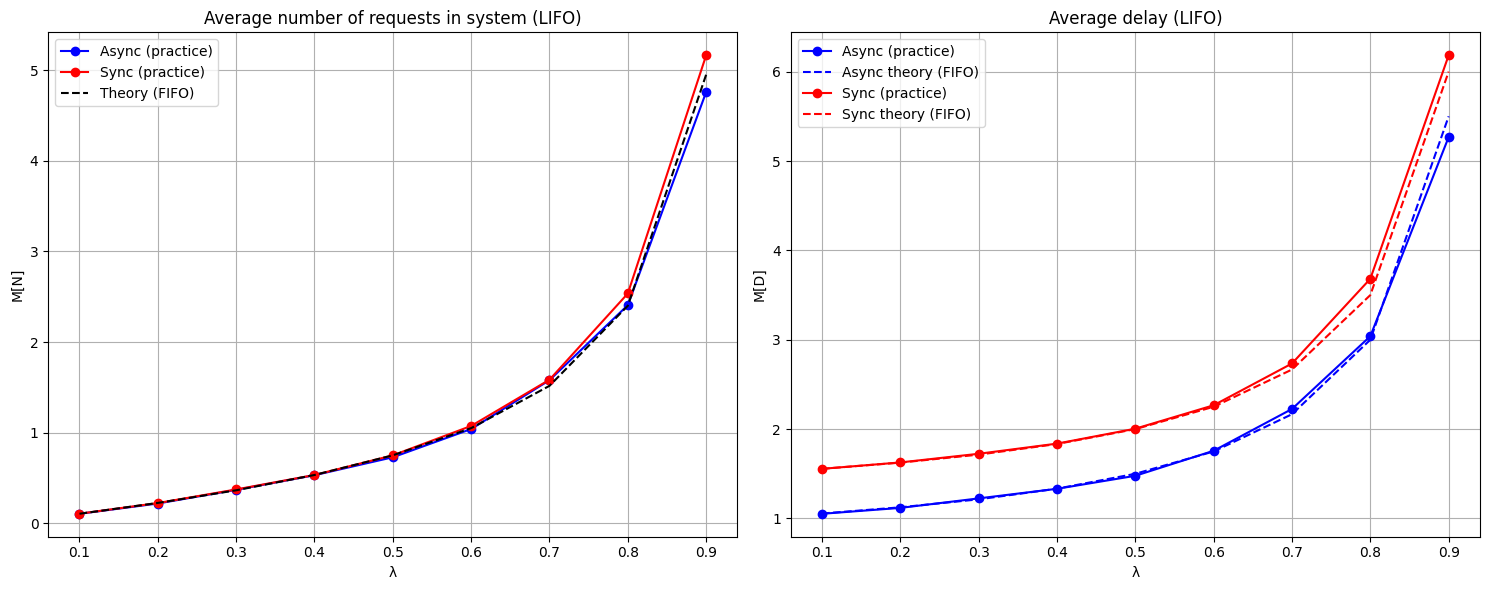

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.mu = 1.0
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = []  # Changed to list for LIFO operations
        self.completed_requests: List[Request] = []
        
    def generate_arrival_times(self, size: int) -> List[float]:
        tau = np.random.exponential(1/self.lambda_param, size)
        return np.cumsum(tau)
        
    def calculate_average_messages(self, timeline: List[float]) -> float:
        M_N = 0
        cur_mes = 0
        number_windows = int(np.ceil(timeline[-1]))
        
        queue = []  # Changed to list for LIFO operations
        for i in range(number_windows):
            if queue:
                queue.pop()  # LIFO: remove from the end instead of beginning
            while cur_mes < len(timeline) and timeline[cur_mes] < i:
                queue.append(cur_mes)
                cur_mes += 1
            M_N += len(queue)
            
        return M_N / number_windows if number_windows > 0 else 0

    def simulate(self, size: int = 100000):
        timeline = self.generate_arrival_times(size)
        times_send = [0.0]  # Start with initial time
        total_delay = 0
        
        t = np.ceil(timeline[0]) + 1
        total_delay += (t - timeline[0])
        times_send.append(t)
        
        for i in range(1, len(timeline)):
            if self.is_synchronous:
                t = np.ceil(timeline[i])
                if t >= times_send[-1]:
                    t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
                else:
                    while t < times_send[-1] + 1:
                        t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
            else:  # Asynchronous
                t = timeline[i]
                if t >= times_send[-1]:
                    t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
                else:
                    t = times_send[-1] + 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
        
        avg_delay = total_delay / size
        avg_messages = self.calculate_average_messages(timeline)
        
        return avg_delay, avg_messages

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    # Note: These theoretical values are for FIFO queue
    # LIFO theoretical values might differ
    N = (lambda_param * (2 - lambda_param)) / (2 * (1 - lambda_param))
    
    D_async = (2 - lambda_param) / (2 * (1 - lambda_param))
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], size: int):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nSimulation Results (LIFO Queue):")
    print("λ\t| M[N] theor\t| M[N] async\t| M[N] sync\t| M[D] async theor\t| M[D] async pract\t| M[D] sync theor\t| M[D] sync pract")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        D_async, N_async = async_system.simulate(size)
        
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        D_sync, N_sync = sync_system.simulate(size)
        
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Async (practice)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Sync (practice)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Theory (FIFO)')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Average number of requests in system (LIFO)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Async (practice)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Async theory (FIFO)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Sync (practice)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Sync theory (FIFO)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Average delay (LIFO)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

lambda_params = np.linspace(0.1, 0.9, 9)
results = compare_systems(lambda_params, 10_000)
plot_results(lambda_params, results)

- Oдинаковое среднее количество сообщений (M[N]), поскольку оно зависит только от скорости поступления/обслуживания
- Одинаковая теоретическая средняя задержка (M[D]) в устойчивом состоянии

* FIFO: Каждый ждет своей очереди - предсказуемые задержки
* LIFO: Новые запросы переходят в очередь - одни получают быстрое обслуживание, другие ждут вечно
* Как прилавок в гастрономе и стопка бумаг: среднее время ожидания одинаковое, но бумаги в самом низу могут никогда не быть обработаны!